# Linear Classifier

--- 

In this lab, we will explore the implementation of a linear classifier from scratch. The topics covered include:

- Initialization of weights and bias
- Matrix multiplication of inputs (X) and weights (theta) with bias
- Activation (Sigmoid, Softmax)
- Loss (cost) function calculation
- Gradient Descent (both batch and stochastic)
- Weight update
- Training

---

## 0. Import necessary libraries

In [4]:
import os
import time
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import torch
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms

import torch.nn as nn
from torchvision import models

## 1. Initialization of Weights and Bias

Before training, we need to initialize our weights (`theta`) and bias (`b`). This can be done randomly or using a small constant value. In most cases, initializing weights with small random values works best to break symmetry, while bias can be initialized to zero.

## 2. Matrix Multiplication of $X$ and $\theta$ with Bias

In linear models, the prediction is computed as the dot product between the input features $X$ and the weight vector $\theta$, plus the bias $b$. Mathematically, this is expressed as:

$$ 
y = X\theta + b 
$$

To incorporate the bias term into the matrix multiplication, we can augment the input matrix $X$ and the weight vector $\theta$. 

### i. Augmenting $X$

Add a column of ones to the input matrix $X$ to account for the bias term. Let $X$ have dimensions $m \times n$ (where $m$ is the number of samples and $n$ is the number of features). The augmented matrix $X_{\text{bias}}$ will have dimensions $m \times (n+1)$:

$$
X_{\text{bias}} = \begin{bmatrix}
1 & x_{11} & x_{12} & \cdots & x_{1n} \\
1 & x_{21} & x_{22} & \cdots & x_{2n} \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
1 & x_{m1} & x_{m2} & \cdots & x_{mn}
\end{bmatrix}
$$

### ii. Augmenting $\theta$

Extend $\theta$ to include the bias term. The extended vector $\theta_{\text{bias}}$ will have dimensions $(n+1) \times c$ (where c is the no. of classes):

$$
\theta_{\text{bias}} = \begin{bmatrix}
b \\
\theta_1 \\
\theta_2 \\
\vdots \\
\theta_n
\end{bmatrix}
$$

### iii. Matrix Multiplication

With the augmented matrix $X_{\text{bias}}$ and the extended vector $\theta_{\text{bias}}$, the prediction $y$ can be computed as:

$$
y = X_{\text{bias}} \theta_{\text{bias}}
$$

This approach simplifies the computation by integrating the bias term directly into the matrix multiplication, which can be more efficient and straightforward in practice, especially when using matrix operations libraries.


In [5]:
# Add bias term (column of 1s) to X
def add_bias_term(X):
    return np.c_[np.ones((X.shape[0], 1)), X]

# X.shape[0] gives the number of rows in X.
# np.ones((X.shape[0], 1)) creates a column vector of ones with the same number of rows.
# np.c_ concatenates the column of ones to the original feature matrix X column-wise.

In [6]:
# Initialize weights with X updated to handle bias
def initialize_parameters(X, y, multiclass):
    n_features = X.shape[1]  # Number of features from the input X with bias term
    if multiclass:
        n_classes = y.shape[1]
        theta = np.random.randn(n_features, n_classes) * 0.01  # Small random weights
    else:
        theta = np.random.randn(n_features, 1) * 0.01  # Small random weights
    return theta

In [7]:
# Linear prediction
def linear_prediction(X, theta):
    return np.dot(X, theta)

## 3. Activation: 

### Binomial Classification (Sigmoid)

In binary classification, the sigmoid function is applied to the linear output to obtain the predicted probability. The sigmoid function $\sigma(z)$ is defined as:

$$
\hat{y} = \sigma(X \theta) = \frac{1}{1 + e^{-X \theta}}
$$

where:
- $\hat{y}$ is the predicted probability.
- $X \theta$ represents the linear combination of the input features $X$ and the weights $\theta$.
- $e$ is the base of the natural logarithm.

The sigmoid function maps the linear output to a probability value between 0 and 1, which can then be used to make a classification decision.

### Multinomial Classification (Softmax)

In multinomial classification, the softmax function is used to compute probabilities across multiple classes. The softmax function $\text{softmax}(z_i)$ for class $k$ is defined as:

$$
\hat{y}_{ik} = \frac{e^{(X \theta_k)}}{\sum_{j=1}^{K} e^{(X \theta_j)}}
$$

where:
- $\hat{y}_{ik}$ is the predicted probability of the $i$-th sample belonging to class $k$.
- $X \theta_k$ is the linear combination of the input features $X$ and the weights $\theta_k$ for class $k$.
- $K$ is the total number of classes.
- The denominator is the sum of the exponentials of the linear combinations for all classes, ensuring that the probabilities sum up to 1.

The softmax function converts the linear outputs into a probability distribution over multiple classes, which is useful for making predictions in multiclass classification problems.


In [9]:
# Sigmoid function for binary classification
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# Softmax function for multi-class
def softmax(z):
    exp_scores = np.exp(z - np.max(z, axis=1, keepdims=True))  # For numerical stability
    return exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

## 4. Loss Functions for Classification

For classification tasks, different loss functions are used depending on whether the task is binary classification or multinomial classification.

### Binary Classification (Sigmoid/Logistic Regression)

The loss function used is binary cross-entropy, also known as log loss. It is defined as:

$$
J(\theta) = -\frac{1}{m} \sum_{i=1}^{m} \left[ y_i \log(\hat{y}_i) + (1 - y_i) \log(1 - \hat{y}_i) \right]
$$

where:
- $m$ is the number of samples.
- $y_i$ is the true label for the $i$-th sample.
- $\hat{y}_i$ is the predicted probability for the $i$-th sample.

### Multinomial Classification (Softmax)

For multinomial classification, especially after one-hot encoding the labels, the loss function is categorical cross-entropy. It is defined as:

$$
J(\theta) = -\frac{1}{m} \sum_{i=1}^{m} \sum_{k=1}^{K} y_{ik} \log(\hat{y}_{ik})
$$

where:
- $m$ is the number of samples.
- $K$ is the number of classes.
- $y_{ik}$ is the one-hot encoded label for the $i$-th sample and $k$-th class (binary indicator: 0 or 1).
- $\hat{y}_{ik}$ is the predicted probability of class $k$ for the $i$-th sample.

In one-hot encoding, $y_{ik}$ is 1 if the $i$-th sample belongs to class $k$, and 0 otherwise. This loss function measures how well the predicted probabilities match the one-hot encoded true labels.

In [8]:
# Binary Cross Entropy Loss
def binary_cross_entropy_loss(y_true, y_pred):
    m = y_true.shape[0]                         # Number of samples
    epsilon = 1e-15                             # To avoid log(0) this is a very small value
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
    return -np.sum(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred)) / m

# Categorical Cross Entropy Loss
def categorical_cross_entropy_loss(y_true, y_pred):
    m = y_true.shape[0]                         # Number of samples
    epsilon = 1e-15                             # To avoid log(0)
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
    return -np.sum(y_true * np.log(y_pred)) / m

## 5. Gradient Descent for Minimizing the Loss Function with weight updates

Gradient descent is used to minimize the loss function by iteratively updating the weights based on the gradient of the loss function.

### Batch Gradient Descent

In Batch Gradient Descent, the gradient is computed using all examples in the dataset:

$$
\theta = \theta - \alpha \frac{\partial J(\theta)}{\partial \theta}
$$

where:
- $\alpha$ is the learning rate.
- $\frac{\partial J(\theta)}{\partial \theta}$ is the gradient of the loss function with respect to the weights.

### Stochastic Gradient Descent (SGD)

In Stochastic Gradient Descent, the gradient is computed using only one example at a time:

$$
\theta = \theta - \alpha \frac{\partial J(\theta)}{\partial \theta}
$$

where:
- $\alpha$ is the learning rate.
- $\frac{\partial J(\theta)}{\partial \theta}$ is the gradient of the loss function with respect to the weights, computed for a single example.

In both cases, the update rule for weights is the same, but the difference lies in how the gradient is computed: either over the entire dataset (Batch Gradient Descent) or a single example (Stochastic Gradient Descent).


## 6. Weight Update
After calculating the gradient, we update the weights using the formula mentioned above. Depending on whether we are using batch gradient descent or stochastic gradient descent, the weight update happens differently.

In [10]:
def gradient_descent_step(X, y, predictions, theta, learning_rate, multiclass):
    m = X.shape[0]
    if multiclass:
        gradients = (1/m) * np.dot(X.T, (predictions - y))
    else:
        gradients = (1/m) * np.dot(X.T, (predictions - y))
    theta = theta - learning_rate * gradients
    return theta

In [11]:
# Stochastic Gradient Descent (SGD) Step
def stochastic_gradient_descent_step(X, y, theta, learning_rate, multiclass):
    m = X.shape[0]
    for i in range(m):
        xi = X[i:i+1]
        yi = y[i:i+1]
        prediction = linear_prediction(xi, theta)
        if multiclass:
            prediction = softmax(prediction)
        else:
            prediction = sigmoid(prediction)
        gradients = np.dot(xi.T, (prediction - yi))
        theta = theta - learning_rate * gradients
    return theta


## 7. Training

In [18]:
# Training function
def train_model(X, y, learning_rate=0.01, iterations=1000, batch=True, multiclass=False):
    # Add bias term to X
    X = add_bias_term(X)
    
    # Initialize theta
    theta = initialize_parameters(X, y, multiclass)
    
    # Track loss over iterations
    losses = []
    
    for i in range(iterations):
        # Compute predictions and loss
        if multiclass:
            predictions = softmax(linear_prediction(X, theta))
            loss = categorical_cross_entropy_loss(y, predictions)
        else:
            predictions = sigmoid(linear_prediction(X, theta))
            loss = binary_cross_entropy_loss(y, predictions)
        
        losses.append(loss)
        
        # Update weights
        if batch:
            theta = gradient_descent_step(X, y, predictions, theta, learning_rate, multiclass)
        else:
            # Use stochastic gradient descent
            theta = stochastic_gradient_descent_step(X, y, theta, learning_rate, multiclass)
        
        # Print loss every 100 iterations
        if i % 200 == 0:
            print(f"Iteration {i}/{iterations}, Loss: {loss:.4f}")
    
    return theta, losses

## Generate Data and Prepare Training and Test Set

In [13]:
# Set multiclass to True or False
multiclass = True  # Set to True for multiclass classification

if multiclass:
    # For multiclass classification
    X_syn, y_syn = make_classification(n_samples=200, n_features=3, n_informative=3, 
                                   n_redundant=0, n_clusters_per_class=1, n_classes=4, random_state=100)
    # Convert y to one-hot encoding
    y_syn = np.eye(np.max(y_syn) + 1)[y_syn]
else:
    # For binary classification
    X_syn, y_syn = make_classification(n_samples=200, n_features=2, n_classes=2, n_informative=2, n_redundant=0, random_state=100)
    y_syn = y_syn.reshape(-1, 1)  # Reshape y to be a column vector

# Split into training and test sets
X_train_syn, X_test_syn, y_train_syn, y_test_syn = train_test_split(X_syn, y_syn, test_size=0.2, random_state=100)

## Visualize Training Data

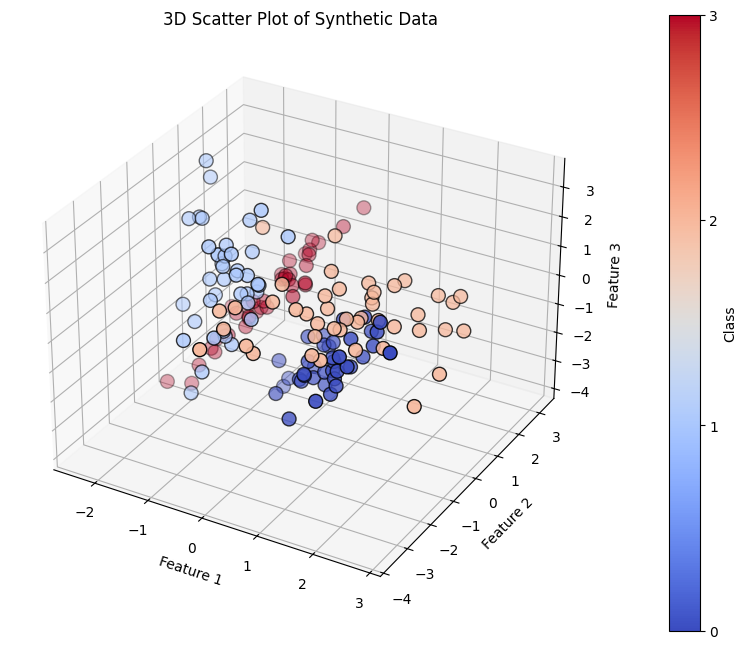

In [14]:
if multiclass:
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    # Convert one-hot encoding to class labels for plotting
    y_train_labels = np.argmax(y_train_syn, axis=1)

    # Use the 3 features for the scatter plot
    scatter = ax.scatter(X_train_syn[:, 0], X_train_syn[:, 1], X_train_syn[:, 2], 
                         c=y_train_labels, cmap='coolwarm', edgecolor='k', s=100)

    # Add labels
    ax.set_title("3D Scatter Plot of Synthetic Data")
    ax.set_xlabel("Feature 1")
    ax.set_ylabel("Feature 2")
    ax.set_zlabel("Feature 3")

    # Add color bar to represent class labels
    cbar = fig.colorbar(scatter, ax=ax, pad=0.1)
    cbar.set_label('Class')
    
    # Set ticks to be integers corresponding to class labels
    cbar.set_ticks(np.arange(np.min(y_train_labels), np.max(y_train_labels) + 1))

    plt.show()
else:
    plt.figure(figsize=(10, 8))
    plt.scatter(X_train_syn[:, 0], X_train_syn[:, 1], c=y_train_syn, cmap='coolwarm', edgecolor='k', s=100)
    plt.title("Scatter Plot of Training Data")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.show()
    

In [19]:
start_time = time.time()
theta, losses = train_model(X_train_syn, y_train_syn, learning_rate=0.01, iterations=5000, batch=True, multiclass=multiclass)
print(f"Time Taken Using Batch gradient descent :{time.time() - start_time}")

Iteration 0/5000, Loss: 1.3832
Iteration 200/5000, Loss: 0.7344
Iteration 400/5000, Loss: 0.5593
Iteration 600/5000, Loss: 0.4801
Iteration 800/5000, Loss: 0.4351
Iteration 1000/5000, Loss: 0.4060
Iteration 1200/5000, Loss: 0.3857
Iteration 1400/5000, Loss: 0.3706
Iteration 1600/5000, Loss: 0.3590
Iteration 1800/5000, Loss: 0.3498
Iteration 2000/5000, Loss: 0.3424
Iteration 2200/5000, Loss: 0.3361
Iteration 2400/5000, Loss: 0.3309
Iteration 2600/5000, Loss: 0.3264
Iteration 2800/5000, Loss: 0.3225
Iteration 3000/5000, Loss: 0.3191
Iteration 3200/5000, Loss: 0.3161
Iteration 3400/5000, Loss: 0.3134
Iteration 3600/5000, Loss: 0.3110
Iteration 3800/5000, Loss: 0.3088
Iteration 4000/5000, Loss: 0.3068
Iteration 4200/5000, Loss: 0.3050
Iteration 4400/5000, Loss: 0.3034
Iteration 4600/5000, Loss: 0.3018
Iteration 4800/5000, Loss: 0.3004
Time Taken Using Batch gradient descent :0.4487953186035156


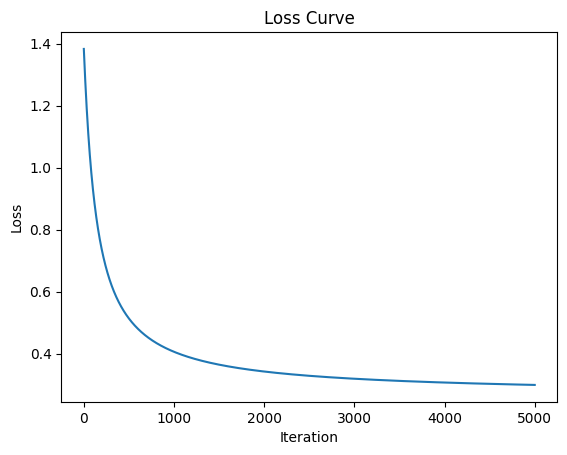

In [20]:
plt.plot(losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.show()

In [21]:
# Add bias term to test data
X_test_bias = add_bias_term(X_test_syn)

if multiclass:
    predictions = softmax(linear_prediction(X_test_bias, theta))
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(y_test_syn, axis=1)
else:
    predictions = sigmoid(linear_prediction(X_test_bias, theta))
    predicted_classes = (predictions >= 0.5).astype(int)
    true_classes = y_test_syn

# Calculate accuracy
accuracy = np.mean(predicted_classes.flatten() == true_classes.flatten())
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Test Accuracy: 92.50%


## For Image what could be possible changes??

In [22]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [ ]:
cifar_train = datasets.CIFAR10('./data', train=True, download=True ,transform=transforms.ToTensor())
cifar_test = datasets.CIFAR10('./data', train=False, download=True ,transform=transforms.ToTensor())

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# Function to subsample CIFAR-10 dataset
def subsample_dataset(dataset, sample_size=1000):
    indices = np.random.choice(len(dataset), sample_size, replace=False)
    subset = Subset(dataset, indices)
    return subset

# Subsample the training and test datasets
sample_size = 1000
train_subset = subsample_dataset(cifar_train, sample_size=sample_size)
test_subset = subsample_dataset(cifar_test, sample_size=int(sample_size * 0.2))

# Load data into PyTorch DataLoader
train_loader = DataLoader(train_subset, batch_size=sample_size, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=int(sample_size * 0.2), shuffle=False)

# Fetch all data and labels for easier handling
X_train, y_train = next(iter(train_loader))
X_test, y_test = next(iter(test_loader))

print("Before Flattening")
print(f"Training data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")

# Reshape the images to 2D tensors and move to device
X_train = X_train.view(X_train.size(0), -1).to(device)  # Flatten
X_test = X_test.view(X_test.size(0), -1).to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

print("After Flattening")
print(f"Training data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")

Before Flattening
Training data shape: torch.Size([1000, 3, 32, 32])
Test data shape: torch.Size([400, 3, 32, 32])
After Flattening
Training data shape: torch.Size([1000, 3072])
Test data shape: torch.Size([400, 3072])


In [ ]:
class ImageLinearClassifier:
    def __init__(self, input_size, n_classes, device=None):
        super().__init__()
        self.device = device or ("cuda" if torch.cuda.is_available() else "cpu")
        print("Using device:", self.device)
        self.W = torch.nn.Parameter(torch.randn(n_classes, input_size, device=self.device) * 0.01)
        self.b = torch.nn.Parameter(torch.zeros(n_classes, device=self.device))

    def predict(self, X):
        # X: (batch_size, input_size)
        X = X.to(self.device)
        return X @ self.W.T + self.b  # (batch_size, n_classes)

    def compute_loss(self, X, y):
        X = X.to(self.device)
        y = y.to(self.device).long()
        logits = self.predict(X)
        return F.cross_entropy(logits, y)

    def gradient_descent(self, X, y, learning_rate=0.001):
        loss = self.compute_loss(X, y)
        loss.backward()
        with torch.no_grad():
            self.W -= learning_rate * self.W.grad
            self.b -= learning_rate * self.b.grad
        self.W.grad.zero_()
        self.b.grad.zero_()
        return loss.item()

In [ ]:
def train(classifier, X_train, y_train, epochs, learning_rate):
    losses = []
    for i in range(epochs):
        loss = classifier.gradient_descent(X_train, y_train, learning_rate)
        losses.append(loss)
        print(f"Epoch {i+1}, Loss: {loss:.4f}")
    return losses

In [29]:
print(f"Training data: {len(cifar_train)}")
print(f"Test data: {len(cifar_test)}")

image, label = cifar_train[0]
# Now you can check the shape of the image
print(f"Image shape: {image.shape}")

Training data: 50000
Test data: 10000
Image shape: torch.Size([3, 32, 32])


In [ ]:
# Example usage
n_classes = 10                                                                  # For CIFAR-10
image_size = 32 * 32 * 3                                                        # CIFAR-10 images are 32x32x3
classifier = ImageLinearClassifier(input_size=image_size, n_classes=n_classes)

# X_train is shape (image_size, batch_size) and y_train is (batch_size,)
losses = train(classifier, X_train, y_train, epochs=100, learning_rate=0.01)

Epoch 1, Loss: 2.321135194144963
Epoch 2, Loss: 2.29373148031079
Epoch 3, Loss: 2.2826375889928396
Epoch 4, Loss: 2.2728935395563203
Epoch 5, Loss: 2.263544870392923
Epoch 6, Loss: 2.2545108167058654
Epoch 7, Loss: 2.2457723984524547
Epoch 8, Loss: 2.237315887115633
Epoch 9, Loss: 2.2291285137851538
Epoch 10, Loss: 2.221198111928634
Epoch 11, Loss: 2.2135130754584544
Epoch 12, Loss: 2.206062342528103
Epoch 13, Loss: 2.198835379967689
Epoch 14, Loss: 2.191822166306586
Epoch 15, Loss: 2.1850131735456593
Epoch 16, Loss: 2.1783993480421766
Epoch 17, Loss: 2.1719720908475466
Epoch 18, Loss: 2.165723237788783
Epoch 19, Loss: 2.159645039535512
Epoch 20, Loss: 2.1537301418497554
Epoch 21, Loss: 2.1479715661766043
Epoch 22, Loss: 2.1423626906998527
Epoch 23, Loss: 2.136897231957575
Epoch 24, Loss: 2.1315692270878994
Epoch 25, Loss: 2.1263730167545036
Epoch 26, Loss: 2.1213032287840683
Epoch 27, Loss: 2.1163547625337427
Epoch 28, Loss: 2.1115227739951052
Epoch 29, Loss: 2.1068026616318156
Epoch 

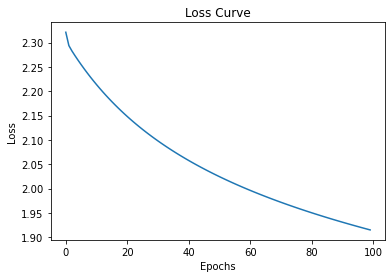

In [31]:
plt.plot(losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.show()

## MLP - Multi Layer Perceptron - DeepLearning

### MLP structure

1. Input Layer: (3072 neurons, corresponding to image size 32x32x3 in CIFAR-10)
2. Hidden Layer 1: Fully connected, with a non-linear activation like ReLU.
3. Output Layer: A fully connected layer with 10 neurons (for 10 classes) and softmax activation.

## Key Components:
1. Input Layer: The input data, similar to your previous setup.
2. Hidden Layer(s): These layers will have weights, biases, and non-linear activations like ReLU.
3. Output Layer: This will have a sigmoid for binomial and softmax activation for multinomial classification.
4. Loss Function: Cross-entropy loss for classification.
5. Backpropagation: To update weights using gradients from the loss.

In [ ]:
class MLPClassifier:
    def __init__(self, input_size, hidden_size, output_size):
        # Weight initialization
        self.W1 = np.random.randn(hidden_size, input_size) * 0.01   # (hidden_size, input_size)
        self.b1 = np.zeros((hidden_size, 1))                        # (hidden_size, 1)
        self.W2 = np.random.randn(output_size, hidden_size) * 0.01  # (output_size, hidden_size)
        self.b2 = np.zeros((output_size, 1))                        # (output_size, 1)
    
    def relu(self, z):
        return np.maximum(0, z)
    
    def relu_derivative(self, z):
        return np.where(z > 0, 1, 0)
    
    def softmax(self, z):
        exp_z = np.exp(z - np.max(z, axis=0, keepdims=True))        # Numerical stability
        return exp_z / np.sum(exp_z, axis=0, keepdims=True)
    
    def forward(self, X):
        """
        Forward pass through the network.
        X: input data of shape (input_size, batch_size)
        """
        # Layer 1 (hidden layer)
        self.Z1 = np.dot(self.W1, X) + self.b1                      # (hidden_size, batch_size)
        self.A1 = self.relu(self.Z1)                                # Apply ReLU activation
        
        # Layer 2 (output layer)
        self.Z2 = np.dot(self.W2, self.A1) + self.b2                # (output_size, batch_size)
        self.A2 = self.softmax(self.Z2)                             # Apply softmax activation
        return self.A2
    
    def compute_loss(self, A2, y):
        """
        Compute cross-entropy loss.
        A2: output from softmax, shape (output_size, batch_size)
        y: true labels, shape (batch_size,)
        """
        m = y.shape[0]                                               # batch size
        log_likelihood = -np.log(A2[y, range(m)])
        loss = np.sum(log_likelihood) / m
        return loss
    
    def backward(self, X, y, learning_rate=0.01):
        """
        Perform backward propagation and update weights.
        X: input data of shape (input_size, batch_size)
        y: true labels of shape (batch_size,)
        """
        m = X.shape[1]                                              # Batch size
        
        # Gradient of the loss w.r.t. Z2
        dZ2 = self.A2                                               # Softmax probabilities
        dZ2[y, range(m)] -= 1                                       # Subtract 1 from the correct class probabilities
        dZ2 /= m
        
        # Gradients for W2 and b2
        dW2 = np.dot(dZ2, self.A1.T)                                # (output_size, hidden_size)
        db2 = np.sum(dZ2, axis=1, keepdims=True)                    # (output_size, 1)

        # Gradients for the hidden layer (backprop through ReLU)
        dA1 = np.dot(self.W2.T, dZ2)                                # (hidden_size, batch_size)
        dZ1 = dA1 * self.relu_derivative(self.Z1)                   # Backprop through ReLU
        
        # Gradients for W1 and b1
        dW1 = np.dot(dZ1, X.T)                                      # (hidden_size, input_size)
        db1 = np.sum(dZ1, axis=1, keepdims=True)                    # (hidden_size, 1)

        # Update weights and biases
        self.W1 -= learning_rate * dW1
        self.b1 -= learning_rate * db1
        self.W2 -= learning_rate * dW2
        self.b2 -= learning_rate * db2
    
    def train(self, X_train, y_train, epochs=100, learning_rate=0.01):
        """
        Train the network.
        X_train: input data, shape (input_size, batch_size)
        y_train: true labels, shape (batch_size,)
        """
        losses = []
        for i in range(epochs):
            # Forward pass
            A2 = self.forward(X_train)
            
            # Compute the loss
            loss = self.compute_loss(A2, y_train)
            print(f'Epoch {i+1}, Loss: {loss}')
            losses.append(loss)
            
            # Backward pass
            self.backward(X_train, y_train, learning_rate)
        return losses


In [ ]:
input_size = 3072           # CIFAR-10 images are 32x32x3
hidden_size = 100           # Arbitrary hidden layer size
output_size = 10            # 10 classes for CIFAR-10

# Move data to CPU and convert to numpy
X_train_np = X_train.detach().cpu().numpy()
y_train_np = y_train.detach().cpu().numpy()

# Use transposed input since your model expects (input_size, batch_size)
X_train_np = X_train_np.T  # shape (3072, 1000)

# Train
mlp = MLPClassifier(input_size, hidden_size, output_size)
losses = mlp.train(X_train_np, y_train_np, epochs=100, learning_rate=0.01)

Epoch 1, Loss: 2.304800833482717
Epoch 2, Loss: 2.303114425199286
Epoch 3, Loss: 2.3017904319958884
Epoch 4, Loss: 2.3006211453298517
Epoch 5, Loss: 2.2995203767241463
Epoch 6, Loss: 2.2984169356171043
Epoch 7, Loss: 2.2972376618072916
Epoch 8, Loss: 2.295977165362549
Epoch 9, Loss: 2.294602398296545
Epoch 10, Loss: 2.29306697590982
Epoch 11, Loss: 2.2913824692969
Epoch 12, Loss: 2.289616657597404
Epoch 13, Loss: 2.2877090628718713
Epoch 14, Loss: 2.2856322623396994
Epoch 15, Loss: 2.2833709602141923
Epoch 16, Loss: 2.280911712825145
Epoch 17, Loss: 2.2782285631481756
Epoch 18, Loss: 2.2752891389225343
Epoch 19, Loss: 2.2720598778529992
Epoch 20, Loss: 2.2685012796197825
Epoch 21, Loss: 2.264587907624589
Epoch 22, Loss: 2.2602878960777972
Epoch 23, Loss: 2.2555535097947597
Epoch 24, Loss: 2.250351249949741
Epoch 25, Loss: 2.2447049423706225
Epoch 26, Loss: 2.238645247949753
Epoch 27, Loss: 2.232154041659306
Epoch 28, Loss: 2.2252345931912565
Epoch 29, Loss: 2.2179242433606454
Epoch 30,

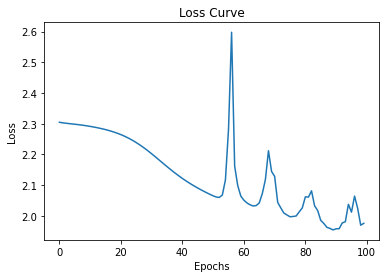

In [34]:
plt.plot(losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.show()